In [1]:
import pandas as pd
import numpy as np
import config as cfg
import json

# Load py2neo
import py2neo
from py2neo import Graph
from py2neo.matching import *

# Throughput Github Analysis

This is a research project led by PhD Simon Goring.

Different research questions are tried to be answer such as: 

- How do individuals and organizations use GitHub (or other public code repositories) to reference, analyze or reuse data from Data Catalogs?

- Are there clear patterns of use across public repositories?

- Do patterns of use differ by data/disciplinary domain, or do properties of the data resource (presence of an API, online documentation, size of user community) affect patterns of use? 

- Does the data reuse observed here expand our understanding of current modes of data reuse, e.g. those outlined in https://datascience.codata.org/articles/10.5334/dsj-2017-008/ ?

- What are the characteristics and shape of the Earth Science research object network?
- What are major nodes of connectivity?
- What poorly connected islands exist? 
- What is the nature of data reuse in this network?
- What downstream/second order grant products can be identified from this network?

## Current Approach

Categorizing a subset of scraped repos, with pre-defined types, which may be updated iteratively as categorization progresses (education, analysis, archiving, informational).


Using ML techniques, we might be able to classify repos according to type automatically; and could consider classifying according to repository quality/completeness. Repository quality or completeness would be defined by:

- presence/absence/length of readme
- number of commits
- number of contributors

By using neo4j, we can construct and analyze the network graph in order to get:
- Centrality and level of connection
- Identification of small networks/islands within the network
- What databases are highly connected and which are not?
- Use database properties (has API, online search portal, has R/Python package, has user forum . . .)

## Objective of the Notebook

This Notebook is going to be used to created an initial Data Exploratory using Neo4j in order to later on, create a Recommendation System using of graph databases. 

In its initial stages, it might look rough, but this will be improved as it is updated and upgraded.

First, let's connect to Neo4j's graph.

There is a `config.py` script, imported as `cfg` that includes personal credentials to log into the database. A `config_sample.py` script has been included. There, change the words `username` and `password` accordingly to match your own credentials.

The port that neo4j automatically usees is 7687 when working in a local database.

In [2]:
# Connect to Graph
graph = Graph("bolt://localhost:7687", auth=(cfg.neo4j['auth']), bolt=True, password=cfg.neo4j['password'])

In [3]:
graph

Graph('bolt://neo4j@localhost:7687', name='neo4j')

In order to select nodes that are a certain kind, we use the command `match`. 

In [4]:
nodes = NodeMatcher(graph)

In [5]:
# Match the first node.
nodes.match("AGENT").first()

Node('AGENT', homepage='https://github.com/throughput-ec/github_scrapers', name='Code scrapers')

In order to run queries, you can do `graph.run()` and do the Querie inside quotes. Although you can convert to dataframe using `to_data_frame()`, I would not recommend it as most of the information is nested.

In [6]:
my_list = graph.run("MATCH (n:AGENT) RETURN n LIMIT 25").to_data_frame()
my_list.head(3)

,n
0,"{'name': 'Code scrapers', 'homepage': 'https:/..."
1,"{'name': 'Keyword synonymy', 'homepage': 'http..."
2,"{'name': 'Simon Goring', 'id': '0000-0002-2700..."


Instead, do `data()` and work with the list of dictionaries to unnest.

In [7]:
trial = graph.run("MATCH (n:AGENT) RETURN n LIMIT 10").data()
trial

[{'n': Node('AGENT', homepage='https://github.com/throughput-ec/github_scrapers', name='Code scrapers')},
 {'n': Node('AGENT', homepage='https://github.com/throughput-ec/throughputdb/keywordMgmt', name='Keyword synonymy')},
 {'n': Node('AGENT', created=1586830369606, id='0000-0002-2700-4605', name='Simon Goring')},
 {'n': Node('AGENT', homepage='https://github.com/throughput-ec/throughputdb', name='Database addition')},
 {'n': Node('AGENT', homepage='https://github.com/throughput-ec/throughputdb/Re3Databases', name='Keyword addition')},
 {'n': Node('AGENT', homepage='https://github.com/throughput-ec/throughputdb/ropensci_libraries', name='Keyword addition')},
 {'n': Node('AGENT', homepage='https://github.com/throughput-ec/throughputdb/ropensci_libraries', name='ROpensci Code Addition')},
 {'n': Node('AGENT', email='', name='Schlesinger, S.')},
 {'n': Node('AGENT', homepage='https://github.com/throughput-ec/throughputdb', name='GitHub code linker')},
 {'n': Node('AGENT', email='chemap@e

As seen above, the nature of nested dictionaries in lists, will definitely represent a challenge when trying to organized data and functions will be needed to make sure each observation's data is appropriately organized in the corresponding features. To convert a list that should be a dictionary use: `json.loads(list_that_should_be_dictionary)`

### Useful queries for counting observations

In [8]:
graph.run('MATCH (crt:TYPE {type:"schema:CodeRepository"})\
           MATCH (crt)<-[:isType]-(ocr:OBJECT) \
           RETURN COUNT(DISTINCT ocr)').to_data_frame()

,COUNT(DISTINCT ocr)
0,73563


# EDA to get the right queries

In order to figure out how to create a ML model, we need to extract the correct data from the Throughput database.

We will analyze and graph the following:
- Distribution of references to DBs

- Note 'Earth Science' databases within graph
    - X = DBs; y = # of referenced repos
    - Linked repos (x) by commits (y)

- Note ES commits 
    - Linked repos (x) by # of contributors (y)
    - Linked repos (x) by # of forks (y)

## Getting DataCatalogs and Counts(CodeRepos)

In [9]:
counts = graph.run('''MATCH (k:KEYWORD {keyword: "earth science"})\
MATCH (k)<-[:hasKeyword]-(:ANNOTATION)-[:Body]->(dc:dataCat)\
MATCH (dc)<-[:Target]-(:ANNOTATION)-[:Target]->(cr:codeRepo)\
RETURN DISTINCT properties(dc), count(DISTINCT cr)''').data()

![](img/01_graph.png)

### Example on extracting data

In [10]:
# Extracting ID of Data Catalog
counts[1]['properties(dc)']['id']

'r3d100010867'

In [11]:
# Extracting number of CodeRepos linked to Data Catalog
counts[1]['count(DISTINCT cr)']

8

In [12]:
# Put DataCatalogs ID's and CodeRepo's counts together

helper_dict={'item': [],
            'counts':[]}

for i in range (0, len(counts)-1):
    helper_dict['item'].append(counts[i]['properties(dc)']['id'])
    helper_dict['counts'].append(counts[i]['count(DISTINCT cr)'])
    
counts_df = pd.DataFrame(helper_dict)
counts_df

,item,counts
0,r3d100010356,7
1,r3d100010867,8
2,r3d100010996,67
3,r3d100012500,4
4,r3d100012046,5
5,r3d100012585,1
6,r3d100010660,12
7,r3d100011524,21
8,r3d100012138,31
9,r3d100010092,24


## Plotting the values

<AxesSubplot:xlabel='item'>

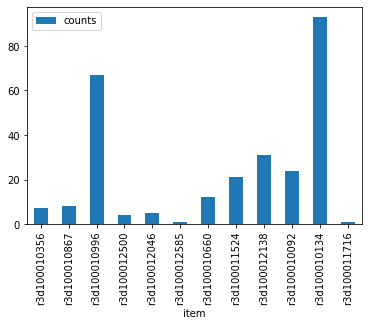

In [45]:
counts_df.plot(x='item', y='counts', kind='bar')

## Getting Other MetaData

In [14]:
data = graph.run('''MATCH (k:KEYWORD {keyword: "earth science"})\
MATCH (k)<-[:hasKeyword]-(a1:ANNOTATION)-[:Body]->(dc:dataCat)\
MATCH (dc)<-[:Target]-(a2:ANNOTATION)-[:Target]->(cr:codeRepo)\
RETURN distinct properties(dc), properties(cr)''').data()

In [15]:
dict1 = data[0]
dict1.keys()

dict_keys(['properties(dc)', 'properties(cr)'])

In [16]:
dict1['properties(dc)']['id']

'r3d100010356'

In [17]:
dict1['properties(cr)']['meta']

'{"id": 37471462, "repo": "ramadda", "owner": "donmurray", "name": "donmurray/ramadda", "url": "https://github.com/donmurray/ramadda", "created": "2015-06-15 (14:49:29.000000)", "description": null, "topics": [], "readme": {"readme": {"readme": true, "badges": 0, "headings": 0, "char": 3369}, "license": "Other"}, "commits": {"totalCommits": 5604, "range": ["2015-06-09 (01:08:44.000000)", "2015-06-13 (12:33:09.000000)"], "authors": [null]}, "languages": {"Java": 10267669, "JavaScript": 1088747, "HTML": 958926, "CSS": 384048, "Tcl": 156286, "Shell": 30045, "Batchfile": 653, "Python": 210}, "stars": 0, "forks": 0, "fork": false, "issues": 0, "branches": 1, "watchers": 0, "checkdate": "2020-11-08 (23:59:26.409711)"}'

In [18]:
len(data)

338

In [19]:
test_string = dict1['properties(cr)']['meta'] # this is a string, from here, using find and REGEX, get commits 

In [20]:
test_string

'{"id": 37471462, "repo": "ramadda", "owner": "donmurray", "name": "donmurray/ramadda", "url": "https://github.com/donmurray/ramadda", "created": "2015-06-15 (14:49:29.000000)", "description": null, "topics": [], "readme": {"readme": {"readme": true, "badges": 0, "headings": 0, "char": 3369}, "license": "Other"}, "commits": {"totalCommits": 5604, "range": ["2015-06-09 (01:08:44.000000)", "2015-06-13 (12:33:09.000000)"], "authors": [null]}, "languages": {"Java": 10267669, "JavaScript": 1088747, "HTML": 958926, "CSS": 384048, "Tcl": 156286, "Shell": 30045, "Batchfile": 653, "Python": 210}, "stars": 0, "forks": 0, "fork": false, "issues": 0, "branches": 1, "watchers": 0, "checkdate": "2020-11-08 (23:59:26.409711)"}'

In [21]:
res = json.loads(test_string) 
res['forks']

0

In [22]:
res['id']

37471462

## Getting CodeRepos and Forks

In [23]:
helper_dict2={'dacat': [],
              'meta':[],
              'cr_item': [],
              'forks':[]}

for i in range (0, len(data)-1):
    helper_dict2['dacat'].append(data[i]['properties(dc)']['id'])
    try:
        helper_dict2['meta'].append(data[i]['properties(cr)']['meta'])
        json_data = json.loads(data[i]['properties(cr)']['meta'])
        helper_data = json_data['id']
        extra_element = json_data['forks']
        helper_dict2['cr_item'].append(helper_data)
        helper_dict2['forks'].append(extra_element)
        
    except KeyError:
        helper_dict2['meta'].append("None2")
        helper_dict2['cr_item'].append("Missing")
        helper_dict2['forks'].append("Missing")
        

#helper_dict2

In [24]:
forks_df = pd.DataFrame(helper_dict2)
forks_df = forks_df[forks_df['meta'] != "None2"]
forks_df

,dacat,meta,cr_item,forks
0,r3d100010356,"{""id"": 37471462, ""repo"": ""ramadda"", ""owner"": ""...",37471462,0
1,r3d100010356,"{""id"": 44131591, ""repo"": ""TextTeaserOnline"", ""...",44131591,0
2,r3d100010356,"{""id"": 185451037, ""repo"": ""IDV-dev-old"", ""owne...",185451037,0
3,r3d100010356,"{""id"": 9786227, ""repo"": ""DELETE_ME.ramadda"", ""...",9786227,0
4,r3d100010356,"{""id"": 38782871, ""repo"": ""scraper"", ""owner"": ""...",38782871,1
...,...,...,...,...
331,r3d100011758,"{""id"": 105052913, ""repo"": ""nasa_data_visualiza...",105052913,1
332,r3d100011758,"{""id"": 212045308, ""repo"": ""dengue-hotspot-pred...",212045308,1
333,r3d100011758,"{""id"": 73648855, ""repo"": ""meteorite-map"", ""own...",73648855,0
334,r3d100011758,"{""id"": 188626320, ""repo"": ""data-prov"", ""owner""...",188626320,0


In [25]:
forks_df=forks_df.drop_duplicates()
forks_df=forks_df[['dacat', 'cr_item', 'forks']].reset_index(drop=True)
forks_df.shape

(328, 3)

In [26]:
forks_df.describe()

,dacat,cr_item,forks
count,328,328,328
unique,13,319,32
top,r3d100010134,229084981,0
freq,93,3,184


### For Repos that have more than 5 forks

Add interactive element to manipulate number of forks

In [27]:
forks_5_plot = forks_df[forks_df['forks']>=10]

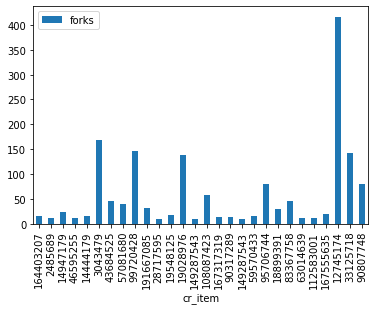

In [28]:
forks_plot = forks_5_plot.plot(x='cr_item', y='forks', kind='bar')

## Extraodinary Repo with a lot of Forks

In [29]:
forks_df[forks_df['forks']>300]

,dacat,cr_item,forks
298,r3d100011758,12745174,417


## Data Catalog it belongs to

In [30]:
forks_df[(forks_df['dacat']=='r3d100011758') & (forks_df['forks']>50)]

,dacat,cr_item,forks
298,r3d100011758,12745174,417
307,r3d100011758,33125718,142
320,r3d100011758,90807748,79


## Getting CodeRepos and GitCommits

In [31]:
# Convert previous logic into a good documented function.

In [32]:
data[1]['properties(cr)']['meta']
example = json.loads(data[1]['properties(cr)']['meta'])


In [33]:
example['commits']['totalCommits']

6

In [34]:
helper_dict3={'dacat': [],
              'meta':[],
              'cr_item': [],
              'commits':[]}


for i in range (0, len(data)-1):
    helper_dict3['dacat'].append(data[i]['properties(dc)']['id'])
    try:
        helper_dict3['meta'].append(data[i]['properties(cr)']['meta'])
        json_data = json.loads(data[i]['properties(cr)']['meta'])
        helper_data = json_data['id']
        extra_element = json_data['commits']['totalCommits']
        helper_dict3['cr_item'].append(helper_data)
        helper_dict3['commits'].append(extra_element)
        
    except KeyError:
        helper_dict3['meta'].append("None2")
        helper_dict3['cr_item'].append("Missing")
        helper_dict3['commits'].append("Missing")

In [35]:
commits_df = pd.DataFrame(helper_dict3)
commits_df = commits_df[commits_df['commits'] != "Missing"]
commits_df = commits_df.drop_duplicates().reset_index(drop=True)
commits_df = commits_df[['dacat', 'cr_item', 'commits']]
commits_df.head(10)

,dacat,cr_item,commits
0,r3d100010356,37471462,5604
1,r3d100010356,44131591,6
2,r3d100010356,185451037,9265
3,r3d100010356,9786227,2526
4,r3d100010356,38782871,23
5,r3d100010356,15574023,3506
6,r3d100010356,39629064,3637
7,r3d100010867,165827878,843
8,r3d100010867,118793166,48
9,r3d100010867,51334355,333


In [36]:
commits_df.shape

(328, 3)

In [37]:
commits_df.describe(include='all')

,dacat,cr_item,commits
count,328,328,328
unique,13,319,181
top,r3d100010134,229084981,4
freq,93,3,14


In [38]:
commits_900_plot = commits_df[commits_df['commits']>=900]

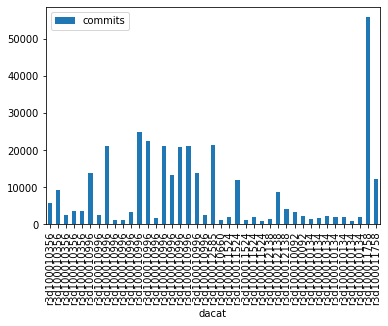

In [39]:
commits_plot = commits_900_plot.plot(x='dacat', y='commits', kind='bar')

## Getting CodeRepos and Contributors

In [40]:
helper_dict4={'dacat': [],
              'meta':[],
              'cr_item': [],
              'contributors':[]}


for i in range (0, len(data)-1):
    helper_dict4['dacat'].append(data[i]['properties(dc)']['id'])
    try:
        helper_dict4['meta'].append(data[i]['properties(cr)']['meta'])
        json_data = json.loads(data[i]['properties(cr)']['meta'])
        helper_data = json_data['id']
        extra_element = json_data['commits']['authors']
        helper_dict4['cr_item'].append(helper_data)
        helper_dict4['contributors'].append(len(extra_element))
        
    except KeyError:
        helper_dict4['meta'].append("None2")
        helper_dict4['cr_item'].append("Missing")
        helper_dict4['contributors'].append("Missing")

In [41]:
contributors_df = pd.DataFrame(helper_dict4)
contributors_df = contributors_df[contributors_df['contributors'] != "Missing"]
contributors_df = contributors_df.drop_duplicates().reset_index(drop=True)
contributors_df = contributors_df[['dacat', 'cr_item', 'contributors']]
contributors_df.head(10)

,dacat,cr_item,contributors
0,r3d100010356,37471462,1
1,r3d100010356,44131591,1
2,r3d100010356,185451037,15
3,r3d100010356,9786227,2
4,r3d100010356,38782871,2
5,r3d100010356,15574023,1
6,r3d100010356,39629064,4
7,r3d100010867,165827878,5
8,r3d100010867,118793166,5
9,r3d100010867,51334355,5


In [42]:
contributors_df.describe()

,dacat,cr_item,contributors
count,328,328,328
unique,13,319,27
top,r3d100010134,229084981,1
freq,93,3,144


In [43]:
contributors_10_plot = contributors_df[contributors_df['contributors']>=10]

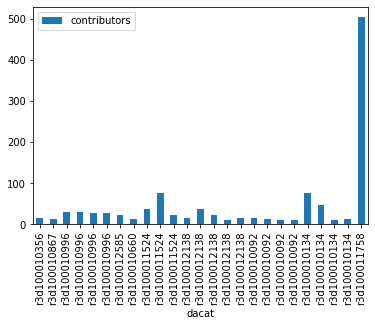

In [44]:
contributors_over_10_plot = contributors_10_plot.plot(x='dacat', y='contributors', kind='bar')